<a href="https://colab.research.google.com/github/wehs7661/deep_learning_projects/blob/master/covid_regression/LR2DNN/covid_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building regression models for predicting COVID-19 daily new cases

In this notebook, we will try to build several different regression models for predicting COVID-19 daily new cases, from a simple linear regression model, to a deep neural network. Notably, this notebook serves as the demonstration of the models explained in [this article], whose figures were all generated by this notebook. 

## Section 0. Import packages

In [1]:
# For data preprocess
import csv
import os
import numpy as np
import pandas as pd

In [2]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [3]:
# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.pyplot import rc
    
# Some plotting settings
rc('font', **{
   'family': 'sans-serif',
   'sans-serif': ['DejaVu Sans'],
   'size': 10
})
# Set the font used for MathJax - more on this later
rc('mathtext', **{'default': 'regular'})
plt.rc('font', family='serif')  

In [4]:
def set_rand_seed(seed=1):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

## Section 1. Understand our dataset

Below we first download the dataset in our case: a timeseries of COVID-19 daily new cases in the United States from January 23, 2020 to July 31, 2022. This dataset is extracted from [Our World in Data](https://ourworldindata.org/explorers/coronavirus-data-explorer?zoomToSelection=true&facet=none&hideControls=true&Metric=Confirmed+cases&Interval=New+per+day&Relative+to+Population=false&Color+by+test+positivity=false&country=~USA) and reformatted for our use.

In [5]:
# Note that this requires the installation of gdown
!gdown --id 1JSYHKqzuDTwhdtfC4dLyptJpj480sxPi --output covid_data.csv

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1JSYHKqzuDTwhdtfC4dLyptJpj480sxPi
To: /content/covid_data.csv
100% 30.3k/30.3k [00:00<00:00, 12.3MB/s]


Below we first read in the data using `pandas`.

In [6]:
df = pd.read_csv('covid_data.csv'); df

,location,date,index,new_cases
0,United States,1/23/20,0,0
1,United States,1/24/20,1,1
2,United States,1/25/20,2,0
3,United States,1/26/20,3,3
4,United States,1/27/20,4,0
...,...,...,...,...
916,United States,7/27/22,916,239176
917,United States,7/28/22,917,147362
918,United States,7/29/22,918,180053
919,United States,7/30/22,919,8888


Then, we can also visualize the time series using `matplotlib`. To get Figure 1 in the article linked above, one could just change the color to white in the first line of the second cell below, and uncomment the last line. 

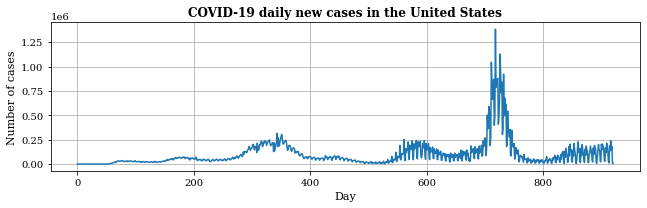

In [7]:
color = 'black'
fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(111)
plt.plot(df['index'], df['new_cases'])
plt.xlabel('Day', color=color, fontsize=11)
plt.ylabel('Number of cases', color=color, fontsize=11)
plt.title('COVID-19 daily new cases in the United States', color=color, fontweight='bold')
plt.grid()

# For better presentation in the webpage
ax.tick_params(color=color, labelcolor=color)
for spine in ax.spines.values():
    spine.set_edgecolor(color)
    
plt.tight_layout()
# plt.savefig('covid_data.png', dpi=600, transparent=True)

## Section 2. Single linear regression model

### Section 2-1. Prepare datasets

As mentioned in the article, we only consider parts of the time series:
- Training set: Days 2 to 799 (index 1 to 798)
- Testing set: Days 800 to 921 (index 799 to 920)

Let's have a quick look at our these two parts of time series before building a model:

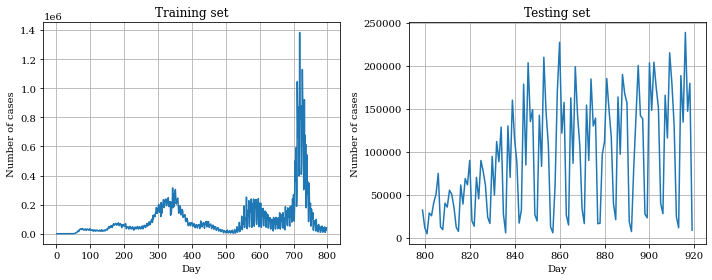

In [8]:
color = 'black'
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121)
plt.plot(df['index'][1:798], df['new_cases'][1:798])
plt.xlabel('Day')
plt.ylabel('Number of cases')
plt.title('Training set')
plt.grid()

ax = fig.add_subplot(122)
plt.plot(df['index'][799:920], df['new_cases'][799:920])
plt.xlabel('Day')
plt.ylabel('Number of cases')
plt.title('Testing set')
plt.grid()
    
plt.tight_layout()
# plt.savefig('covid_data.png', dpi=600, transparent=True)

And here we define our first linear regression model as $y=b+wx_1$, where $y$ is the number of cases on Day $n$, and $x_1$ is the number of cases on Day $n-1$, so the training set and test set can be defined as follows. Notably, each data set is $k$ by 2, with $k$ being the number of samples in the dataset (and the 2 columns include $x_1$ and $y$).

To make the preparation of datasets in later cases more convenient, we write the class `COVID19Dataset`. Note that for a model of $m$ features, we consider the new cases 1 day before, 2 days before, ..., up to $m$ days before. When preparing the dataset, we also standardize the data to eliminate the influence of units.

In [9]:
class COVID19Dataset(Dataset):
    def __init__(self, df, n_feats, mode, tr_idx=(1, 798), tt_idx=(799, 920)):
        self.mode = mode
        whole_data = np.array([list(df['new_cases'][:-n_feats]), list(df['new_cases'][n_feats:])]).transpose()
        
        if mode == 'test':
            data = np.array([df['new_cases'][tt_idx[0]-n : tt_idx[1]-n] for n in np.arange(n_feats, -1, -1)]).transpose()
            x = data[:, list(range(n_feats))]   # features
            y = data[:, -1]  # target
            self.x = torch.FloatTensor(x)
            self.y = torch.FloatTensor(y)
           
        else:
            # splitting training data into train & dev sets (we take 20% of the data as the validation set)
            data = np.array([df['new_cases'][tr_idx[0]-n : tr_idx[1]-n] for n in np.arange(n_feats, -1, -1)]).transpose()
            x = data[:, list(range(n_feats))]   # features
            y = data[:, -1]  # target
            
            if mode == 'train':
                idx = [i for i in range(len(x)) if i % 5 != 0]
            elif mode == 'dev':
                idx = [i for i in range(len(x)) if i % 5 == 0]
            
            self.x = torch.FloatTensor(x[idx])
            self.y = torch.FloatTensor(y[idx])
        
        self.y_mean = self.y.mean()
        self.y_std = self.y.std()
        
        # Standardize features
        self.x =(self.x - self.x.mean()) / self.x.std()
        self.y =(self.y - self.y.mean()) / self.y.std()
        
        self.dim = self.x.shape[1]
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return len(self.x)

### Section 2-2. Build and train the model

First of all, we define the linear regression model below.

In [10]:
class LinearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(LinearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)
        self.criterion = torch.nn.L1Loss()  # mean absolute error
    
    def forward(self, x):
        out = self.linear(x).squeeze(1)  # `squeeze` makes the tensor from n by 1 to n (same as y)
        return out
    
    def calc_loss(self, pred, target):
        return self.criterion(pred, target)

Then, we define the following function for training the model.

In [11]:
def dev(dv_set, model):
    model.eval()                  # set model to evaluation mode
    total_loss = 0
    for x, y in dv_set:
        with torch.no_grad():     # disable gradient calculation
            pred = model(x)
            loss = model.calc_loss(pred, y)
        total_loss += loss.detach().item() * len(x)
    avg_loss = total_loss / len(dv_set.dataset)
    
    return avg_loss

In [12]:
def train(tr_set, dv_set, model, config):
    """config: A dictionary of parameters like n_epochs, lr, ..."""
    n_epochs = config['n_epochs']
    
    # Set up optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(model.parameters(), config['lr'])
    
    min_loss = 1000      # just set to a large number. This will be updated later
    loss_list = {'train': [], 'dev': []}
    epoch = 0
    early_stop_cnt = 0
    while epoch < n_epochs:
        model.train()                                 # set the model to training mode
        for x, y in tr_set:
            optimizer.zero_grad()                     # clear graident buffers as we don't cumulate gradients 
            x, y = x.to('cpu'), y.to('cpu')
            pred = model(x)
            loss = model.calc_loss(pred, y)
            loss.backward()                           # compute graidents w.r.t the parameters (backpropagation)
            optimizer.step()                          # update parameters
            # loss_list['train'].append(loss.item())  # if we append here, we will have loss for every batch
        loss_list['train'].append(loss.item())        # Here we will have loss for each epoch
             
        # After each epoch, test the model on the validation (development) set
        dev_loss = dev(dv_set, model)
        if dev_loss < min_loss:
            # Save the model if your model improved
            min_loss = dev_loss
            # print(f'Saving model (epoch = {epoch + 1}, loss = {min_loss:.4f})')
            # torch.save(model.state_dict(), config['save_path'])
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1
        
        epoch += 1
        loss_list['dev'].append(dev_loss)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break
            
    print(f'Finished training after {epoch} epochs')
    return loss_list

Now, let's load in the data, set up the parameters and start training!

In [13]:
def prep_dataloader(df, n_feats, mode, batch_size, tr_idx=(1, 798), tt_idx=(799, 920)):
    dataset = COVID19Dataset(df, n_feats, mode, tr_idx=tr_idx, tt_idx=tt_idx)
    dataloader = DataLoader(dataset, batch_size, shuffle=(mode=='train'))
    
    return dataloader

In [14]:
config = {
    'n_epochs': 5000,
    'lr': 0.001,
    'optimizer': 'SGD',
    'batch_size': 200,
    'early_stop': 1000, 
}

In [15]:
set_rand_seed()
tr_set = prep_dataloader(df, 1, 'train', config['batch_size'])
dv_set = prep_dataloader(df, 1, 'dev', config['batch_size'])
tt_set = prep_dataloader(df, 1, 'test', config['batch_size'])

In [16]:
model = LinearRegression(1, 1)
loss_list = train(tr_set, dv_set, model, config)

Finished training after 1467 epochs


### Section 2-3. Assess the model

#### 1. Training/validation loss as a function of time

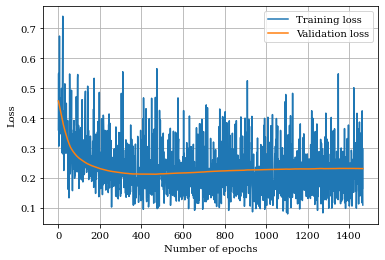

In [17]:
plt.figure()
plt.plot(loss_list['train'], label='Training loss')
plt.plot(loss_list['dev'], label='Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

#### 2. Comparison between the predicted and true time series

Below we compare the predictions made by the model and the true values. Note that here we convert the standardized data back to the original scale.

In [18]:
# Z score
pred_tr_z = model(tr_set.dataset.x) 
pred_dev_z = model(dv_set.dataset.x)
pred_tt_z = model(tt_set.dataset.x)

label_tr_z = tr_set.dataset.y  
label_dev_z = dv_set.dataset.y
label_tt_z = tt_set.dataset.y

# Original scale
pred_tr = pred_tr_z * tr_set.dataset.y_std + tr_set.dataset.y_mean
pred_dev = pred_dev_z * dv_set.dataset.y_std + dv_set.dataset.y_mean
pred_tt = pred_tt_z * tt_set.dataset.y_std + tt_set.dataset.y_mean

label_tr = label_tr_z * tr_set.dataset.y_std + tr_set.dataset.y_mean
label_dev = label_dev_z * dv_set.dataset.y_std + dv_set.dataset.y_mean
label_tt = label_tt_z * tt_set.dataset.y_std + tt_set.dataset.y_mean

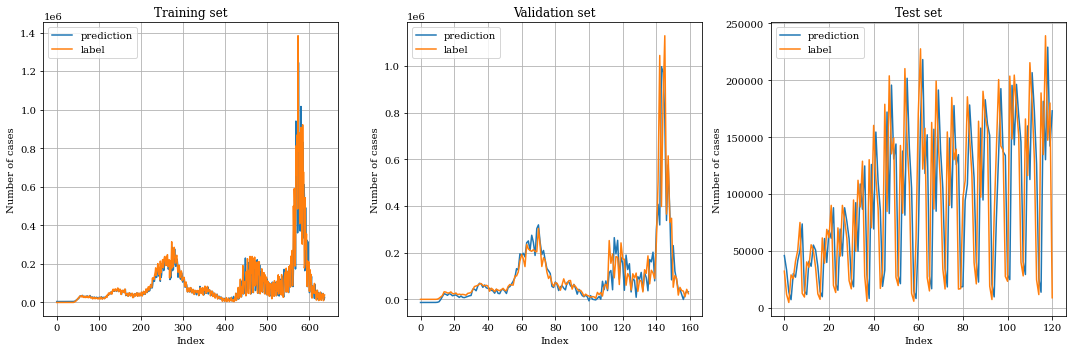

In [19]:
preds = [pred_tr, pred_dev, pred_tt]
labels = [label_tr, label_dev, label_tt]
titles = ['Training set', 'Validation set', 'Test set']

plt.figure(figsize=(15, 5))
for i in range(len(preds)):
    plt.subplot(1, 3, i + 1)
    plt.plot(preds[i].detach().numpy(), label='prediction')
    plt.plot(labels[i].detach().numpy(), label='label')

    plt.xlabel('Index')
    plt.ylabel('Number of cases')
    plt.title(titles[i])
    plt.legend()
    plt.grid()

plt.tight_layout()

#### 3. Average loss

Below we calculate the average training loss, validation loss, and test loss in the original scale.

In [20]:
print(f'Training loss: {model.calc_loss(pred_tr, label_tr).detach().item():.0f}')
print(f'Validation loss: {model.calc_loss(pred_dev, label_dev).detach().item():.0f}')
print(f'Test loss: {model.calc_loss(pred_tt, label_tt).detach().item():.0f}')

Training loss: 30725
Validation loss: 36773
Test loss: 55134


Notably, the plots above show that the predicted time series are lagged by 1 data point (1 day) by the true time series. This is because we were making predictions based on the data history. (Check [this discussion](https://www.quora.com/What-do-lag-and-lead-mean-in-a-prediction-problem-in-machine-learning) for more.) If we shift our predictions by 1 data point, it will almost overlap with the true values, as shown below.

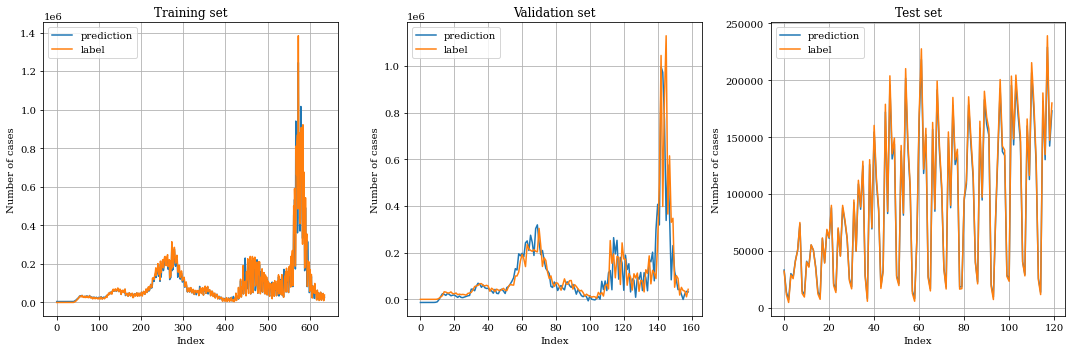

In [21]:
preds = [pred_tr, pred_dev, pred_tt]
labels = [label_tr, label_dev, label_tt]
titles = ['Training set', 'Validation set', 'Test set']

plt.figure(figsize=(15, 5))
for i in range(len(preds)):
    plt.subplot(1, 3, i + 1)
    plt.plot(preds[i].detach().numpy()[1:], label='prediction')
    plt.plot(labels[i].detach().numpy()[:-1], label='label')

    plt.xlabel('Index')
    plt.ylabel('Number of cases')
    plt.title(titles[i])
    plt.legend()
    plt.grid()

plt.tight_layout()

And if we calculate the average loss based on the shifted predictions, the loss would be even lower.

In [22]:
print(f'Training loss: {model.calc_loss(pred_tr[1:], label_tr[:-1]).detach().item():.0f}')
print(f'Validation loss: {model.calc_loss(pred_dev[1:], label_dev[:-1]).detach().item():.0f}')
print(f'Test loss: {model.calc_loss(pred_tt[1:], label_tt[:-1]).detach().item():.0f}')

Training loss: 13447
Validation loss: 44773
Test loss: 3311


Notably, validation loss increases after the predicted time series is shifted by 1 day. This is because that adjacent points in the time series in the validation set do not correspond to adjacent dates, while this is the case for the the training and test sets.

#### 4. Correlation plot

Below we plot the correlation plots between our predictions and the true values. Ideally, the cluster of data should be around the diagonal line of $y=x$.

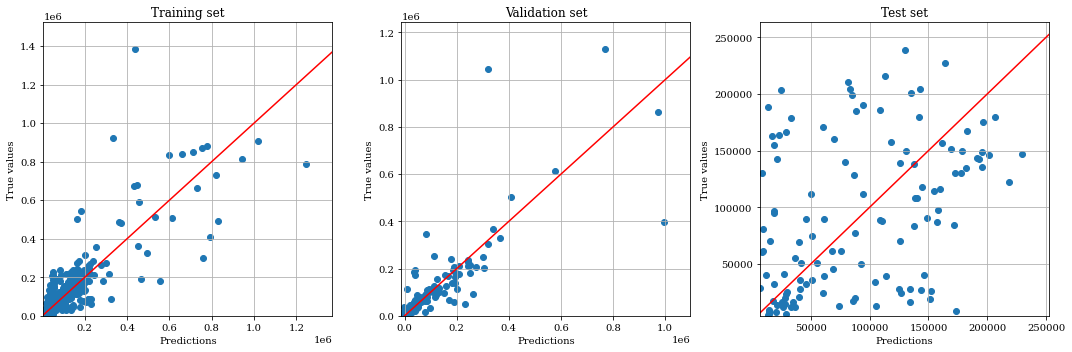

In [23]:
datasets = [tr_set, dv_set, tt_set]
plt.figure(figsize=(15, 5))
for i in range(len(datasets)):
    plt.subplot(1, 3, i + 1)
    plt.scatter(preds[i].detach().numpy(), labels[i].detach().numpy())
    plt.plot([-200000, 5000000], [-200000, 5000000], color='red')
    plt.xlabel('Predictions')
    plt.ylabel('True values')
    plt.xlim([min(preds[i].detach().numpy()) * 0.9, max(preds[i].detach().numpy()) * 1.1])
    plt.ylim([min(labels[i].detach().numpy()) * 0.9, max(labels[i].detach().numpy()) * 1.1])
    plt.title(titles[i])
    plt.grid()

plt.tight_layout()

#### 5. Regression line

Here let's check the slope and intercept of the regression line.

In [24]:
print(list(model.parameters()))
w = list(model.parameters())[0]
b = list(model.parameters())[1]

[Parameter containing:
tensor([[0.9423]], requires_grad=True), Parameter containing:
tensor([-0.0289], requires_grad=True)]


As shown above, the linear regression model is as follows: $$\left(\frac{y-\bar{y}}{\sigma_y} \right)=0.9423\left(\frac{x-\bar{x}}{\sigma_x} \right)-0.0289$$

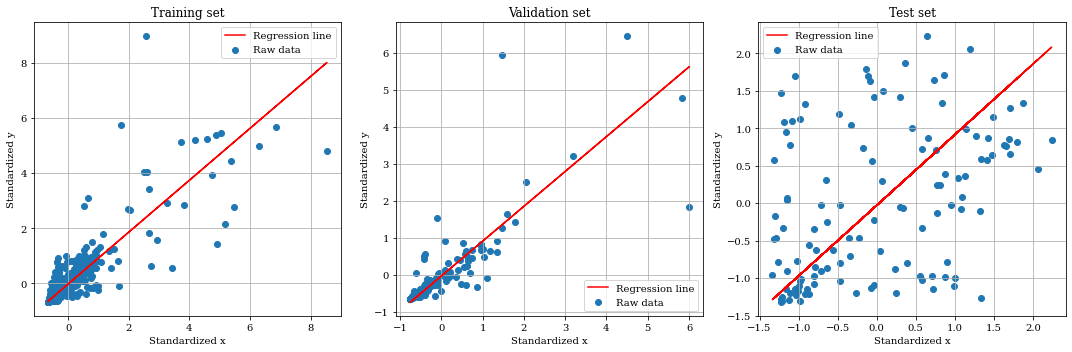

In [25]:
plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 3, i)
for i in range(len(datasets)):
    plt.subplot(1, 3, i + 1)
    plt.scatter(datasets[i].dataset.x, datasets[i].dataset.y, label='Raw data')
    plt.plot(datasets[i].dataset.x.detach().numpy(), [(i * w + b).detach().item() for i in datasets[i].dataset.x], color='red', label='Regression line')
    plt.xlabel('Standardized x')
    plt.ylabel('Standardized y')
    plt.title(titles[i])
    plt.grid()
    plt.legend()

plt.tight_layout()

Note that these plots look pretty similar to the correlation plots between the predictions and the true values. This is just because that $x$ and $y$ are roughly of the same magnitudes most of the time in the datasets.

## Section 3. Multiple linear regression (MLR) model

In this section, we will explore linear regression models with multiple features, i.e. multiple linear regression (MLR) models. Specifically, we will consider models with the following form: $$y=b + \sum_{i} w_{i}x_{i}$$ where $y$ is the number of new cases on Day $n$, and $x_i$ is the number of new cases on Day $n-i$. 

Below we will use exactly the same set of hpyerparameters and explore different numbers of features, including 7, 28, and 56. To save space, we define the following function that trains and assess the models. 

In [26]:
def MultipleLinearRegression(n_feats):
    
    ###############################
    #  Build and train the model  #
    ###############################
    
    config = {
        'n_epochs': 5000,
        'lr': 0.001,
        'optimizer': 'SGD',
        'batch_size': 200,
        'early_stop': 1000, 
    }
    
    set_rand_seed()
    tr_set = prep_dataloader(df, n_feats, 'train', config['batch_size'], tr_idx=(n_feats + 1, 798))
    dv_set = prep_dataloader(df, n_feats, 'dev', config['batch_size'], tr_idx=(n_feats + 1, 798))
    tt_set = prep_dataloader(df, n_feats, 'test', config['batch_size'], tr_idx=(n_feats + 1, 798))
    
    model = LinearRegression(n_feats, 1) 
    loss_list = train(tr_set, dv_set, model, config)
    
    ######################
    #  Assess the model  #
    ######################
    
    # 1. Loss as a function of time
    plt.figure()
    plt.plot(loss_list['train'], label='Training loss')
    plt.plot(loss_list['dev'], label='Validation loss')
    plt.xlabel('Number of epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    
    # 2. Compare between the predicted and true time series
    
    # Z score
    pred_tr_z = model(tr_set.dataset.x) 
    pred_dev_z = model(dv_set.dataset.x)
    pred_tt_z = model(tt_set.dataset.x)

    label_tr_z = tr_set.dataset.y  
    label_dev_z = dv_set.dataset.y
    label_tt_z = tt_set.dataset.y

    # Original scale
    pred_tr = pred_tr_z * tr_set.dataset.y_std + tr_set.dataset.y_mean
    pred_dev = pred_dev_z * dv_set.dataset.y_std + dv_set.dataset.y_mean
    pred_tt = pred_tt_z * tt_set.dataset.y_std + tt_set.dataset.y_mean

    label_tr = label_tr_z * tr_set.dataset.y_std + tr_set.dataset.y_mean
    label_dev = label_dev_z * dv_set.dataset.y_std + dv_set.dataset.y_mean
    label_tt = label_tt_z * tt_set.dataset.y_std + tt_set.dataset.y_mean
    
    preds = [pred_tr, pred_dev, pred_tt]
    labels = [label_tr, label_dev, label_tt]
    titles = ['Training set', 'Validation set', 'Test set']

    plt.figure(figsize=(15, 5))
    for i in range(len(preds)):
        plt.subplot(1, 3, i + 1)
        plt.plot(preds[i].detach().numpy(), label='prediction')
        plt.plot(labels[i].detach().numpy(), label='label')

        plt.xlabel('Index')
        plt.ylabel('Number of cases')
        plt.title(titles[i])
        plt.legend()
        plt.grid()

    plt.tight_layout()
    
    # 3. Average loss
    print(f'Training loss: {model.calc_loss(pred_tr, label_tr).detach().item():.0f}')
    print(f'Validation loss: {model.calc_loss(pred_dev, label_dev).detach().item():.0f}')
    print(f'Test loss: {model.calc_loss(pred_tt, label_tt).detach().item():.0f}')
    
    # 4. Correlation plots
    datasets = [tr_set, dv_set, tt_set]
    plt.figure(figsize=(15, 5))
    for i in range(len(datasets)):
        plt.subplot(1, 3, i + 1)
        plt.scatter(preds[i].detach().numpy(), labels[i].detach().numpy())
        plt.plot([-200000, 5000000], [-200000, 5000000], color='red')
        plt.xlabel('Predictions')
        plt.ylabel('True values')
        plt.xlim([min(preds[i].detach().numpy()) * 0.9, max(preds[i].detach().numpy()) * 1.1])
        plt.ylim([min(labels[i].detach().numpy()) * 0.9, max(labels[i].detach().numpy()) * 1.1])
        plt.title(titles[i])
        plt.grid()

    plt.tight_layout()

Finished training after 2695 epochs
Training loss: 21312
Validation loss: 26617
Test loss: 31560


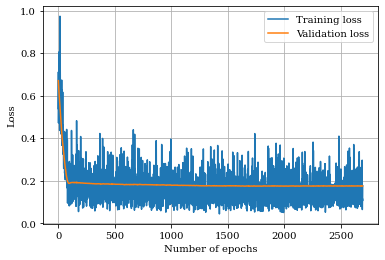

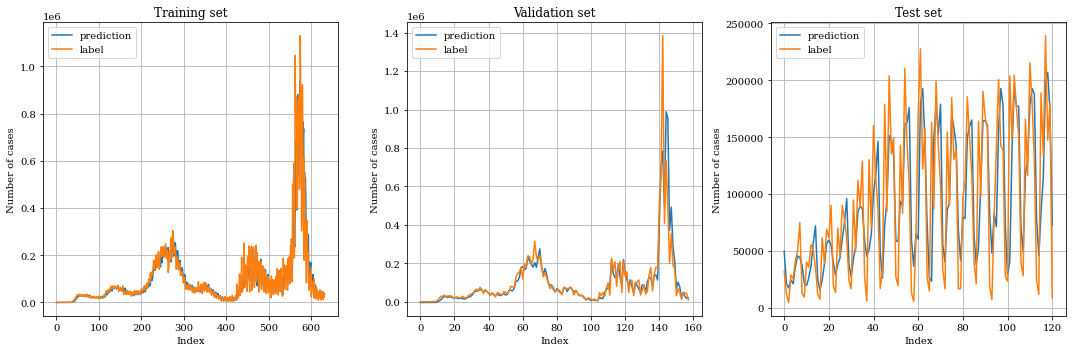

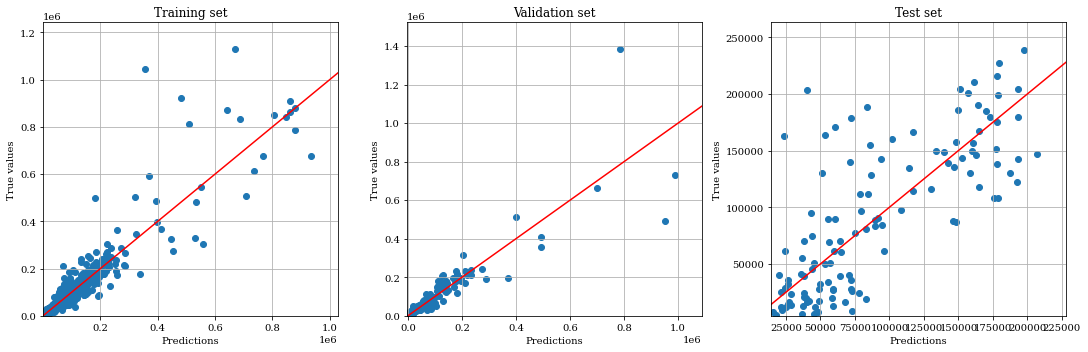

In [ ]:
MultipleLinearRegression(n_feats=7)

Finished training after 5000 epochs
Training loss: 16224
Validation loss: 17685
Test loss: 25765


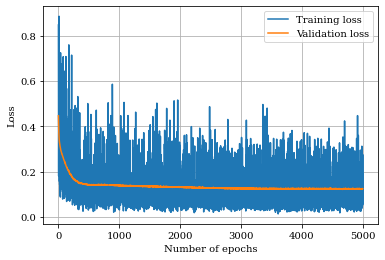

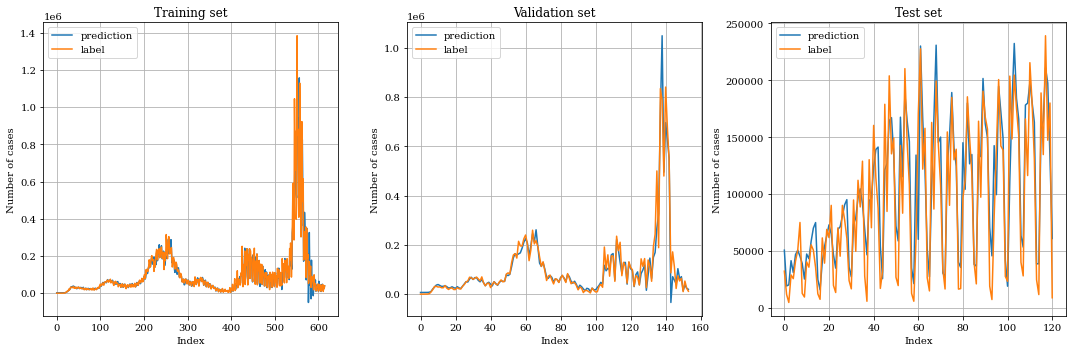

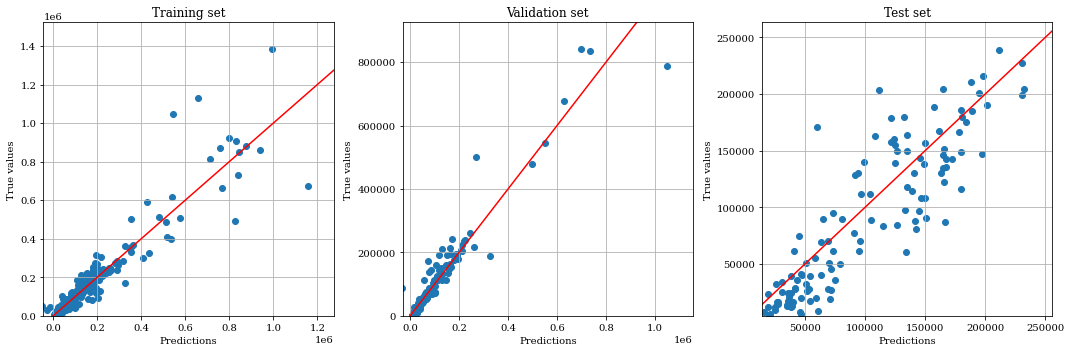

In [27]:
MultipleLinearRegression(n_feats=28)

Finished training after 3116 epochs
Training loss: 16545
Validation loss: 18172
Test loss: 28925


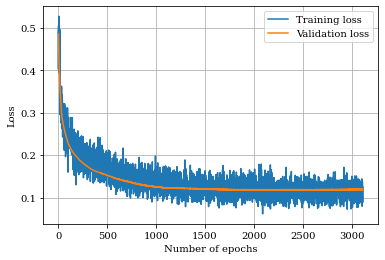

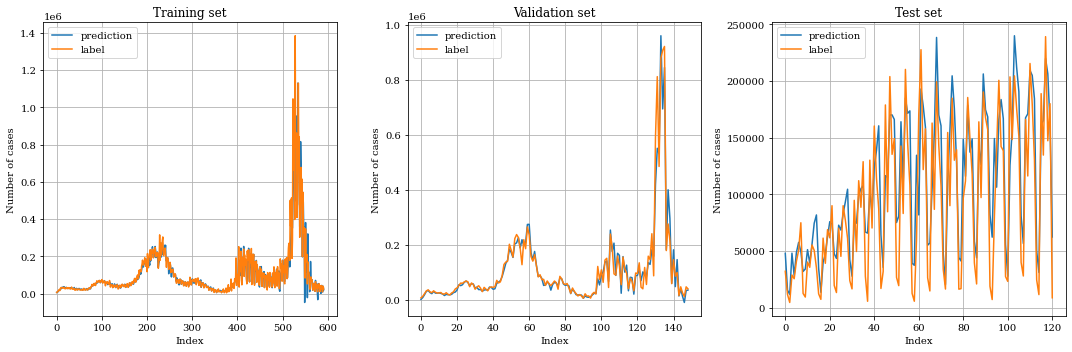

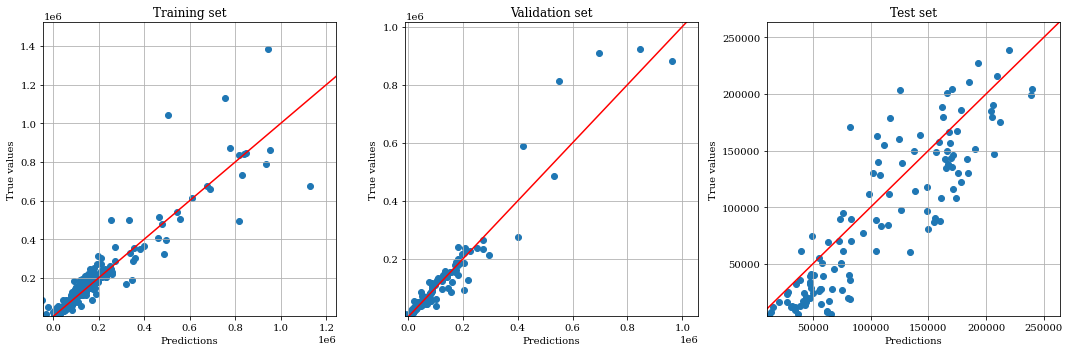

In [28]:
MultipleLinearRegression(n_feats=56)

Finished training after 5000 epochs
Training loss: 15940
Validation loss: 26057
Test loss: 44254


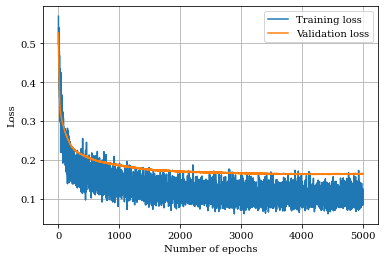

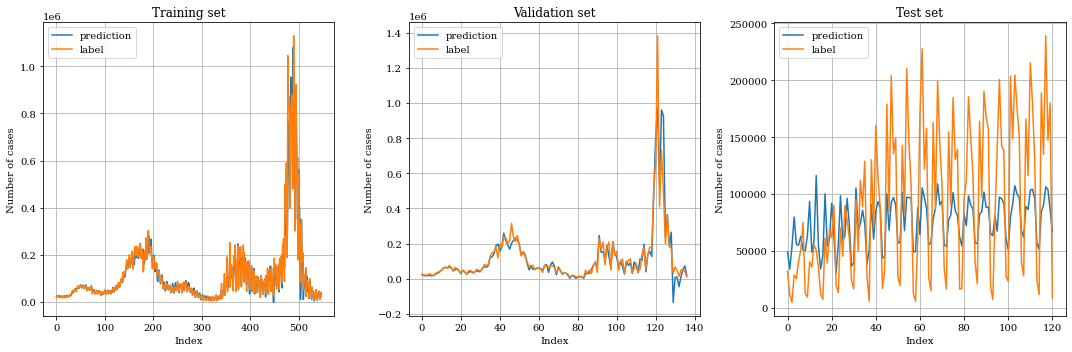

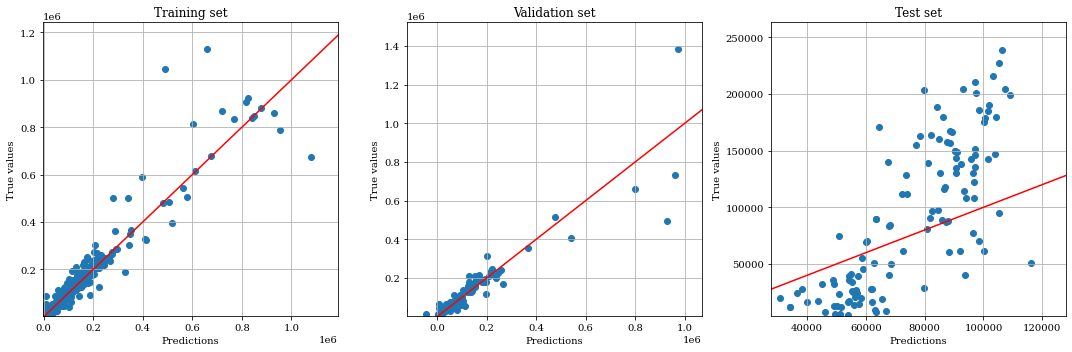

In [29]:
MultipleLinearRegression(n_feats=112)

In [ ]:
print(f'Training loss: {model.calc_loss(pred_tr[1:], label_tr[:-1]).detach().item():.0f}')
print(f'Validation loss: {model.calc_loss(pred_dev[1:], label_dev[:-1]).detach().item():.0f}')
print(f'Test loss: {model.calc_loss(pred_tt[1:], label_tt[:-1]).detach().item():.0f}')

### Section 3-3. A summary of linear regression models

## Section 4. Deep neural networks